In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [2]:
complaints = pd.read_excel('EaUgXb.xlsx', index_col = 0)
clients = pd.read_excel('btUTgX.xlsx', index_col=0)

In [3]:
churn = clients['Churn']

In [4]:
# merge complaints and churn, keeping only values of churn for which there is a customerID in complaints
complaints = complaints.merge(churn, left_on='customerID', right_index=True)

In [5]:
complaints.drop(columns=['complaint_number'], inplace=True)

In [6]:
complaints.rename(columns={'Churn': 'churn'}, inplace=True)

In [7]:
complaints['churn'] = complaints['churn'].map({'No': 0, 'Yes': 1})

In [8]:
# check classes are balanced
complaints['churn'].value_counts(normalize=True)

churn
1    0.617445
0    0.382555
Name: proportion, dtype: float64

We expect people who complain to churn more, so it makes sense (the dataset seems to be well representative).

## **Embedding + Visualization**
Useless (no insight) ma lascio il codice qua nel caso possa servire.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=500)  # Limit number of features for easier visualization
X = vectorizer.fit_transform(complaints['complaint']).toarray()


In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

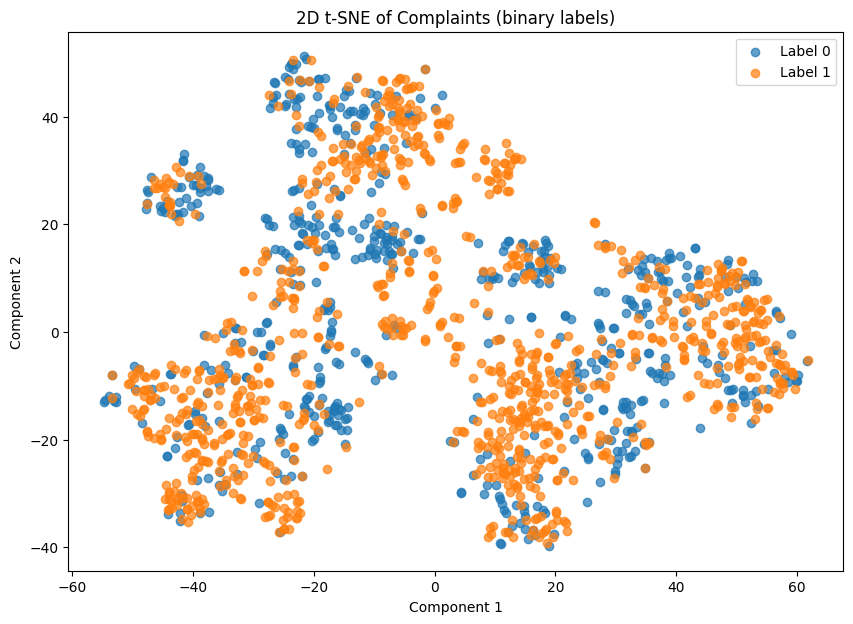

In [30]:
import matplotlib.pyplot as plt
# Step 3: Plot
plt.figure(figsize=(10, 7))
for label in [0, 1]:
    idx = complaints['churn'] == label
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=f'Label {label}', alpha=0.7)

plt.legend()
plt.title('2D t-SNE of Complaints (binary labels)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [31]:
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(X)

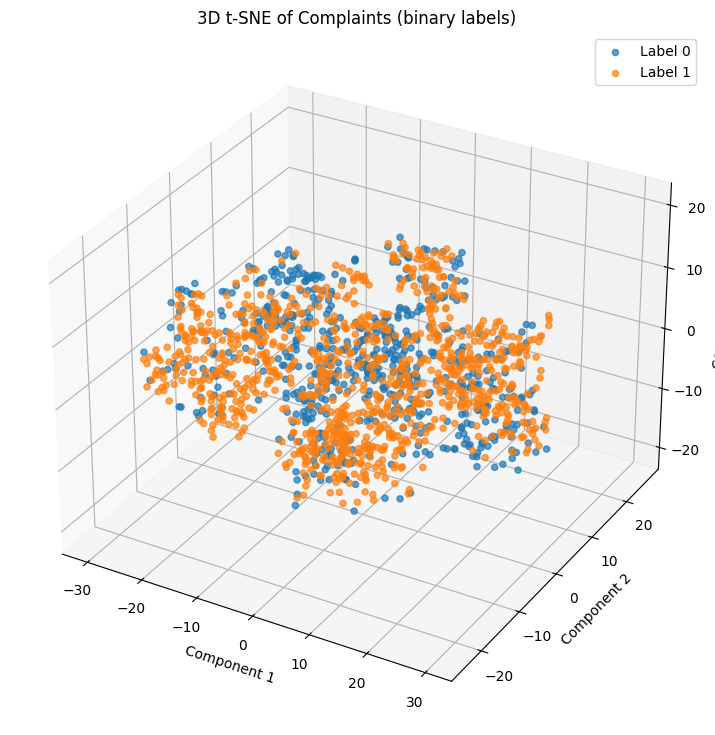

In [32]:
from mpl_toolkits.mplot3d import Axes3D

# Step 3: Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for label in [0, 1]:
    idx = complaints['churn'] == label
    ax.scatter(X_embedded[idx, 0], X_embedded[idx, 1], X_embedded[idx, 2], label=f'Label {label}', alpha=0.7)

ax.set_title('3D t-SNE of Complaints (binary labels)')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.legend()
plt.show()

In [9]:
from sentence_transformers import SentenceTransformer

# Load a powerful small model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the text data
X = model.encode(complaints['complaint'].tolist(), show_progress_bar=True)


Batches:   0%|          | 0/51 [00:00<?, ?it/s]

In [38]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, random_state=42)
# X_embedded = tsne.fit_transform(X)

import umap

reducer = umap.UMAP(n_components=2, random_state=42)
X_embedded = reducer.fit_transform(X)

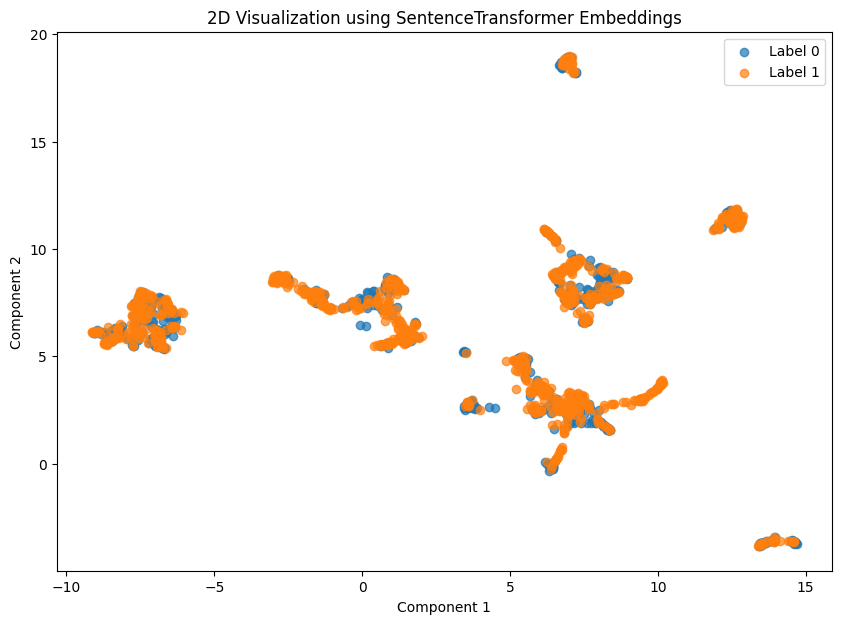

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
for label in [0, 1]:
    idx = complaints['churn'] == label
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=f'Label {label}', alpha=0.7)

plt.legend()
plt.title('2D Visualization using SentenceTransformer Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [40]:
from sklearn.manifold import TSNE

# t-SNE to 3D
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(X)

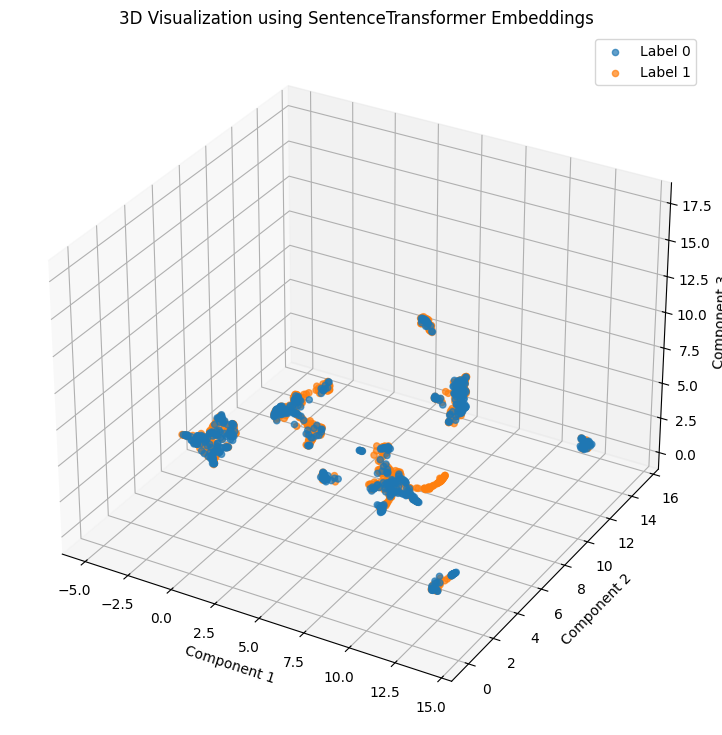

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for label in [0, 1]:
    idx = complaints['churn'] == label
    ax.scatter(X_embedded[idx, 0], X_embedded[idx, 1], X_embedded[idx, 2], label=f'Label {label}', alpha=0.7)

ax.set_title('3D Visualization using SentenceTransformer Embeddings')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.legend()
plt.show()

In [43]:
import umap

# UMAP to 3D
reducer = umap.UMAP(n_components=3, random_state=42)
X_embedded = reducer.fit_transform(X)

## **Classifier**

In [10]:
import numpy as np

y = complaints['churn'].values

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on test set
y_pred = clf.predict(X_test)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7133956386292835
Confusion Matrix:
 [[ 54  69]
 [ 23 175]]
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.44      0.54       123
           1       0.72      0.88      0.79       198

    accuracy                           0.71       321
   macro avg       0.71      0.66      0.67       321
weighted avg       0.71      0.71      0.70       321



In [19]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


clf = CatBoostClassifier(verbose=0)  # suppress training output
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7227414330218068
Confusion Matrix:
 [[ 62  61]
 [ 28 170]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.50      0.58       123
           1       0.74      0.86      0.79       198

    accuracy                           0.72       321
   macro avg       0.71      0.68      0.69       321
weighted avg       0.72      0.72      0.71       321



In [20]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7071651090342679
Confusion Matrix:
 [[ 60  63]
 [ 31 167]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.49      0.56       123
           1       0.73      0.84      0.78       198

    accuracy                           0.71       321
   macro avg       0.69      0.67      0.67       321
weighted avg       0.70      0.71      0.70       321



In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# 1. Prepare Data
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 2. Define a deeper MLP model
class DeeperNN(nn.Module):
    def __init__(self):
        super(DeeperNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(X_train.shape[1], 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output probability for binary classification
        )
    
    def forward(self, x):
        return self.net(x)

# 3. Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeeperNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 20

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# 4. Evaluate
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (outputs.cpu().numpy() > 0.5).astype(int)
        y_pred.extend(preds.flatten())
        y_true.extend(labels.numpy())

from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("Classification Report:\n", classification_report(y_true, y_pred))


Epoch [1/20], Loss: 0.6455
Epoch [2/20], Loss: 0.5509
Epoch [3/20], Loss: 0.5263
Epoch [4/20], Loss: 0.4757
Epoch [5/20], Loss: 0.4621
Epoch [6/20], Loss: 0.4335
Epoch [7/20], Loss: 0.4255
Epoch [8/20], Loss: 0.4107
Epoch [9/20], Loss: 0.3921
Epoch [10/20], Loss: 0.3685
Epoch [11/20], Loss: 0.3473
Epoch [12/20], Loss: 0.3980
Epoch [13/20], Loss: 0.3696
Epoch [14/20], Loss: 0.3916
Epoch [15/20], Loss: 0.3602
Epoch [16/20], Loss: 0.3330
Epoch [17/20], Loss: 0.3299
Epoch [18/20], Loss: 0.3426
Epoch [19/20], Loss: 0.3535
Epoch [20/20], Loss: 0.3063
Accuracy: 0.7383177570093458
Confusion Matrix:
 [[ 71  52]
 [ 32 166]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.58      0.63       123
         1.0       0.76      0.84      0.80       198

    accuracy                           0.74       321
   macro avg       0.73      0.71      0.71       321
weighted avg       0.73      0.74      0.73       321

